In [2]:
import numpy as np 
import pandas as pd 
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer
from pyspark.ml.linalg import Vectors
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import StringIndexer,OneHotEncoder
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf,col
from pyspark.sql.types import DoubleType,IntegerType,FloatType
import matplotlib.pylab as plt

In [3]:
spSession = SparkSession.builder.master("local").appName("Spark_CostPrediction").getOrCreate()
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")


22/11/15 01:38:51 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [4]:
#baixando o csv e deixando o spark verificar seu schema(atribuir automaticamente)
df = spark.read.options(header='True', inferSchema='True').csv("data/mediapredictionandcost.csv")
df.printSchema()

root
 |-- food_category: string (nullable = true)
 |-- food_department: string (nullable = true)
 |-- food_family: string (nullable = true)
 |-- store_sales(in millions): double (nullable = true)
 |-- store_cost(in millions): double (nullable = true)
 |-- unit_sales(in millions): double (nullable = true)
 |-- promotion_name: string (nullable = true)
 |-- sales_country: string (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- total_children: double (nullable = true)
 |-- education: string (nullable = true)
 |-- member_card: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- houseowner: string (nullable = true)
 |-- avg_cars_at home(approx): double (nullable = true)
 |-- avg_yearly_income: string (nullable = true)
 |-- num_children_at_home: double (nullable = true)
 |-- brand_name: string (nullable = true)
 |-- SRP: double (nullable = true)
 |-- gross_weight: double (nullable = true)
 |-- net_weight: double (nu

<h2>analise inicial e separacao de dados</h2>

In [5]:
df.columns

['food_category',
 'food_department',
 'food_family',
 'store_sales(in millions)',
 'store_cost(in millions)',
 'unit_sales(in millions)',
 'promotion_name',
 'sales_country',
 'marital_status',
 'gender',
 'total_children',
 'education',
 'member_card',
 'occupation',
 'houseowner',
 'avg_cars_at home(approx)',
 'avg_yearly_income',
 'num_children_at_home',
 'brand_name',
 'SRP',
 'gross_weight',
 'net_weight',
 'recyclable_package',
 'low_fat',
 'units_per_case',
 'store_type',
 'store_city',
 'store_state',
 'store_sqft',
 'grocery_sqft',
 'frozen_sqft',
 'meat_sqft',
 'coffee_bar',
 'video_store',
 'salad_bar',
 'prepared_food',
 'florist',
 'media_type',
 'cost']

In [6]:
df.toPandas()

22/11/15 01:39:03 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,food_category,food_department,food_family,store_sales(in millions),store_cost(in millions),unit_sales(in millions),promotion_name,sales_country,marital_status,gender,...,grocery_sqft,frozen_sqft,meat_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,media_type,cost
0,Breakfast Foods,Frozen Foods,Food,7.36,2.7232,4.0,Bag Stuffers,USA,M,F,...,18670.0,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,"Daily Paper, Radio",126.62
1,Breakfast Foods,Frozen Foods,Food,5.52,2.5944,3.0,Cash Register Lottery,USA,M,M,...,18670.0,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,"Daily Paper, Radio",59.86
2,Breakfast Foods,Frozen Foods,Food,3.68,1.3616,2.0,High Roller Savings,USA,S,F,...,18670.0,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,"Daily Paper, Radio",84.16
3,Breakfast Foods,Frozen Foods,Food,3.68,1.1776,2.0,Cash Register Lottery,USA,M,F,...,18670.0,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,In-Store Coupon,95.78
4,Breakfast Foods,Frozen Foods,Food,4.08,1428.0000,3.0,Double Down Sale,USA,M,M,...,18670.0,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,Radio,50.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60423,Specialty,Carousel,Non-Consumable,2.76,1.3248,1.0,You Save Days,USA,M,F,...,15321.0,4294.0,2863.0,1.0,0.0,0.0,0.0,0.0,In-Store Coupon,95.25
60424,Specialty,Carousel,Non-Consumable,1.60,496.0000,1.0,Price Cutters,USA,S,F,...,15321.0,4294.0,2863.0,1.0,0.0,0.0,0.0,0.0,Sunday Paper,69.42
60425,Specialty,Carousel,Non-Consumable,5.52,2.5392,2.0,Weekend Markdown,USA,M,M,...,15321.0,4294.0,2863.0,1.0,0.0,0.0,0.0,0.0,"Sunday Paper, Radio, TV",67.51
60426,Specialty,Carousel,Non-Consumable,8.28,2.5668,3.0,Sales Days,Canada,S,M,...,27463.0,4193.0,2795.0,1.0,0.0,0.0,0.0,1.0,Sunday Paper,132.88


In [7]:
df.take(2)

[Row(food_category='Breakfast Foods', food_department='Frozen Foods', food_family='Food', store_sales(in millions)=7.36, store_cost(in millions)=2.7232, unit_sales(in millions)=4.0, promotion_name='Bag Stuffers', sales_country='USA', marital_status='M', gender='F', total_children=1.0, education='Partial High School', member_card='Normal', occupation='Skilled Manual', houseowner='Y', avg_cars_at home(approx)=1.0, avg_yearly_income='$10K - $30K', num_children_at_home=1.0, brand_name='Carrington', SRP=1.84, gross_weight=19.7, net_weight=17.7, recyclable_package=1.0, low_fat=0.0, units_per_case=17.0, store_type='Deluxe Supermarket', store_city='Salem', store_state='OR', store_sqft=27694.0, grocery_sqft=18670.0, frozen_sqft=5415.0, meat_sqft=3610.0, coffee_bar=1.0, video_store=1.0, salad_bar=1.0, prepared_food=1.0, florist=1.0, media_type='Daily Paper, Radio', cost=126.62),
 Row(food_category='Breakfast Foods', food_department='Frozen Foods', food_family='Food', store_sales(in millions)=5.5

In [8]:
#separando as variaveis categoricas e numericas iterando o dtypes
categorica= [item[0] for item in df.dtypes if item[1].startswith('string')]
numerica = [item[0] for item in df.dtypes if item[1].startswith('double')]

In [9]:
print(categorica)

['food_category', 'food_department', 'food_family', 'promotion_name', 'sales_country', 'marital_status', 'gender', 'education', 'member_card', 'occupation', 'houseowner', 'avg_yearly_income', 'brand_name', 'store_type', 'store_city', 'store_state', 'media_type']


In [10]:
#separando em categoricas e numericas
dfcat=df.select(*categorica)
dfnum=df.select(*numerica)

In [11]:
#excluindo a variavel avg que contem uma faixa de valores ex:$10K - $30K
dfcat=dfcat.drop("avg_yearly_income")

In [12]:
df.groupBy('food_category').count().show()
#equivalente ao valuecounts

+--------------------+-----+
|       food_category|count|
+--------------------+-----+
|     Breakfast Foods| 1946|
|     Frozen Desserts| 1446|
|       Starchy Foods| 1103|
|        Baking Goods| 1947|
|   Cleaning Supplies|  748|
|                Meat| 3107|
|    Jams and Jellies| 2550|
|       Hot Beverages|  891|
|          Vegetables| 7440|
|               Dairy| 3835|
|         Snack Foods| 6919|
|               Candy| 1538|
|       Decongestants|  396|
|       Canned Shrimp|  182|
|               Bread| 1797|
|             Seafood|  375|
|Carbonated Beverages|  782|
|    Kitchen Products|  969|
|             Candles|  195|
|           Specialty| 1174|
+--------------------+-----+
only showing top 20 rows



In [13]:
#transformando as categoricas em numeros
indexer = StringIndexer(inputCols=[cols for cols in dfcat.columns], 
                   outputCols=[cols + "1" for cols in dfcat.columns])
indexer_fitted = indexer.fit(dfcat)
dfcat2 = indexer_fitted.transform(dfcat)
dfcat2 = dfcat2.drop(*[cols for cols in dfcat.columns])
dfcat2.toPandas()

,food_category1,food_department1,food_family1,promotion_name1,sales_country1,marital_status1,gender1,education1,member_card1,occupation1,houseowner1,brand_name1,store_type1,store_city1,store_state1,media_type1
0,7.0,3.0,0.0,30.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,12.0,1.0,1.0,1.0,0.0
1,7.0,3.0,0.0,14.0,0.0,1.0,1.0,2.0,3.0,0.0,0.0,12.0,1.0,1.0,1.0,0.0
2,7.0,3.0,0.0,9.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,12.0,1.0,1.0,1.0,0.0
3,7.0,3.0,0.0,14.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,12.0,1.0,1.0,1.0,7.0
4,7.0,3.0,0.0,8.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,16.0,1.0,1.0,1.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60423,16.0,21.0,1.0,28.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,106.0,4.0,15.0,2.0,7.0
60424,16.0,21.0,1.0,27.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,107.0,4.0,15.0,2.0,6.0
60425,16.0,21.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,106.0,4.0,15.0,2.0,12.0
60426,16.0,21.0,1.0,26.0,2.0,0.0,1.0,2.0,0.0,0.0,1.0,106.0,3.0,17.0,5.0,6.0


In [14]:
print(dfcat2)

DataFrame[food_category1: double, food_department1: double, food_family1: double, promotion_name1: double, sales_country1: double, marital_status1: double, gender1: double, education1: double, member_card1: double, occupation1: double, houseowner1: double, brand_name1: double, store_type1: double, store_city1: double, store_state1: double, media_type1: double]


In [15]:
# analisando as viariaveis numericas

In [16]:
#estas variaveis estao como numericas ,mas,sao categoricas
dfnum.groupBy('florist','prepared_food','salad_bar','coffee_bar','video_store','recyclable_package','low_fat').count().show()
dfnumcat=dfnum.select('florist','prepared_food','salad_bar','coffee_bar','video_store','recyclable_package','low_fat')
dfnum=dfnum.drop(*[cols for cols in dfnumcat.columns])
print(dfnumcat)

+-------+-------------+---------+----------+-----------+------------------+-------+-----+
|florist|prepared_food|salad_bar|coffee_bar|video_store|recyclable_package|low_fat|count|
+-------+-------------+---------+----------+-----------+------------------+-------+-----+
|    0.0|          0.0|      0.0|       1.0|        0.0|               1.0|    0.0| 2588|
|    1.0|          0.0|      0.0|       1.0|        0.0|               0.0|    1.0|   89|
|    1.0|          1.0|      1.0|       1.0|        1.0|               1.0|    0.0| 7968|
|    1.0|          1.0|      1.0|       1.0|        0.0|               1.0|    0.0| 2872|
|    0.0|          1.0|      1.0|       0.0|        0.0|               1.0|    1.0| 1174|
|    1.0|          0.0|      0.0|       0.0|        0.0|               1.0|    0.0| 1474|
|    0.0|          0.0|      0.0|       0.0|        0.0|               0.0|    0.0| 3767|
|    1.0|          1.0|      1.0|       1.0|        0.0|               1.0|    1.0| 1587|
|    0.0| 

In [17]:
#juntando (numericas que sao categoricas com as variaveis categoricas ja definidas) 
df1=dfnumcat.toPandas()
df2=dfcat2.toPandas()
df3=pd.concat([df1, df2], axis=1, join='inner')

dfcat2=spark.createDataFrame(df3) 

In [18]:
dfcat2.columns

['florist',
 'prepared_food',
 'salad_bar',
 'coffee_bar',
 'video_store',
 'recyclable_package',
 'low_fat',
 'food_category1',
 'food_department1',
 'food_family1',
 'promotion_name1',
 'sales_country1',
 'marital_status1',
 'gender1',
 'education1',
 'member_card1',
 'occupation1',
 'houseowner1',
 'brand_name1',
 'store_type1',
 'store_city1',
 'store_state1',
 'media_type1']

In [19]:
#variaveis numericas antes de mudar a escala
dfnum.toPandas()

,store_sales(in millions),store_cost(in millions),unit_sales(in millions),total_children,avg_cars_at home(approx),num_children_at_home,SRP,gross_weight,net_weight,units_per_case,store_sqft,grocery_sqft,frozen_sqft,meat_sqft,cost
0,7.36,2.7232,4.0,1.0,1.0,1.0,1.84,19.70,17.70,17.0,27694.0,18670.0,5415.0,3610.0,126.62
1,5.52,2.5944,3.0,0.0,4.0,0.0,1.84,19.70,17.70,17.0,27694.0,18670.0,5415.0,3610.0,59.86
2,3.68,1.3616,2.0,4.0,1.0,0.0,1.84,19.70,17.70,17.0,27694.0,18670.0,5415.0,3610.0,84.16
3,3.68,1.1776,2.0,2.0,2.0,2.0,1.84,19.70,17.70,17.0,27694.0,18670.0,5415.0,3610.0,95.78
4,4.08,1428.0000,3.0,0.0,2.0,0.0,1.36,7.12,5.11,29.0,27694.0,18670.0,5415.0,3610.0,50.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60423,2.76,1.3248,1.0,1.0,1.0,1.0,2.76,19.60,18.60,26.0,22478.0,15321.0,4294.0,2863.0,95.25
60424,1.60,496.0000,1.0,2.0,2.0,0.0,1.60,17.40,15.30,36.0,22478.0,15321.0,4294.0,2863.0,69.42
60425,5.52,2.5392,2.0,1.0,3.0,0.0,2.76,19.60,18.60,26.0,22478.0,15321.0,4294.0,2863.0,67.51
60426,8.28,2.5668,3.0,2.0,4.0,0.0,2.76,19.60,18.60,26.0,34452.0,27463.0,4193.0,2795.0,132.88


In [20]:
#analise estatistica
dfnum.toPandas().describe()

,store_sales(in millions),store_cost(in millions),unit_sales(in millions),total_children,avg_cars_at home(approx),num_children_at_home,SRP,gross_weight,net_weight,units_per_case,store_sqft,grocery_sqft,frozen_sqft,meat_sqft,cost
count,60428.000000,60428.000000,60428.000000,60428.000000,60428.000000,60428.000000,60428.000000,60428.000000,60428.000000,60428.000000,60428.000000,60428.000000,60428.000000,60428.000000,60428.000000
mean,6.541031,714.371465,3.093169,2.533875,2.200271,0.829351,2.115258,13.806433,11.796289,18.860694,27988.477494,19133.799696,5312.852552,3541.846280,99.262366
std,3.463047,1405.516069,0.827677,1.490165,1.109644,1.303424,0.932829,4.622693,4.682986,10.258555,5701.022090,3987.395735,1575.907263,1050.471635,30.011257
min,0.510000,0.163200,1.000000,0.000000,0.000000,0.000000,0.500000,6.000000,3.050000,1.000000,20319.000000,13305.000000,2452.000000,1635.000000,50.790000
25%,3.810000,1.846800,3.000000,1.000000,1.000000,0.000000,1.410000,9.700000,7.710000,10.000000,23593.000000,16232.000000,4746.000000,3164.000000,69.650000
50%,5.940000,3.169200,3.000000,3.000000,2.000000,0.000000,2.130000,13.600000,11.600000,19.000000,27694.000000,18670.000000,5062.000000,3375.000000,98.520000
75%,8.670000,826.000000,4.000000,4.000000,3.000000,1.000000,2.790000,17.700000,16.000000,28.000000,30797.000000,22123.000000,5751.000000,3834.000000,126.620000
max,22.920000,9525.000000,6.000000,5.000000,4.000000,5.000000,3.980000,21.900000,20.800000,36.000000,39696.000000,30351.000000,9184.000000,6122.000000,149.750000


In [21]:
#variavel target
target=dfnum.select("cost")

In [22]:
#escalando as variaveis numericas
dfnum2=dfnum

# UDF para converter coluna para vetor 
unlist = udf(lambda x: round(float(list(x)[0]),3), DoubleType())

# iterando as colunas
for i in [cols for cols in dfnum2.columns]:
    
    # convertendo coluna para vetor
    assembler = VectorAssembler(inputCols=[i],outputCol=i+"_Vect")

    # MinMaxScaler 
    scaler = MinMaxScaler(inputCol=i+"_Vect", outputCol=i+"_Scaled")

    # Pipeline 
    pipeline = Pipeline(stages=[assembler, scaler])

    # preenchendo pipeline no dataframe
    dfnum2 = pipeline.fit(dfnum2).transform(dfnum2).withColumn(i+"_Scaled", unlist(i+"_Scaled")).drop(i+"_Vect")

#dropando as colunas anteriores e a coluna target
dfnum2=dfnum2.drop('store_sales(in millions)', 'store_cost(in millions)', 'unit_sales(in millions)',
                   'total_children', 'avg_cars_at home(approx)', 'num_children_at_home', 'SRP',
                   'gross_weight', 'net_weight', 'recyclable_package', 'low_fat', 'units_per_case',
                   'store_sqft', 'grocery_sqft', 'frozen_sqft', 'meat_sqft', 'coffee_bar', 'video_store',
                   'salad_bar', 'prepared_food', 'florist', 'cost','cost_Scaled')

print("After Scaling :")
dfnum2.show(1)

After Scaling :


+-------------------------------+------------------------------+------------------------------+---------------------+-------------------------------+---------------------------+----------+-------------------+-----------------+---------------------+-----------------+-------------------+------------------+----------------+
|store_sales(in millions)_Scaled|store_cost(in millions)_Scaled|unit_sales(in millions)_Scaled|total_children_Scaled|avg_cars_at home(approx)_Scaled|num_children_at_home_Scaled|SRP_Scaled|gross_weight_Scaled|net_weight_Scaled|units_per_case_Scaled|store_sqft_Scaled|grocery_sqft_Scaled|frozen_sqft_Scaled|meat_sqft_Scaled|
+-------------------------------+------------------------------+------------------------------+---------------------+-------------------------------+---------------------------+----------+-------------------+-----------------+---------------------+-----------------+-------------------+------------------+----------------+
|                          0.30

In [23]:
dfnum2.toPandas()

,store_sales(in millions)_Scaled,store_cost(in millions)_Scaled,unit_sales(in millions)_Scaled,total_children_Scaled,avg_cars_at home(approx)_Scaled,num_children_at_home_Scaled,SRP_Scaled,gross_weight_Scaled,net_weight_Scaled,units_per_case_Scaled,store_sqft_Scaled,grocery_sqft_Scaled,frozen_sqft_Scaled,meat_sqft_Scaled
0,0.306,0.000,0.6,0.2,0.25,0.2,0.385,0.862,0.825,0.457,0.381,0.315,0.440,0.440
1,0.224,0.000,0.4,0.0,1.00,0.0,0.385,0.862,0.825,0.457,0.381,0.315,0.440,0.440
2,0.141,0.000,0.2,0.8,0.25,0.0,0.385,0.862,0.825,0.457,0.381,0.315,0.440,0.440
3,0.141,0.000,0.2,0.4,0.50,0.4,0.385,0.862,0.825,0.457,0.381,0.315,0.440,0.440
4,0.159,0.150,0.4,0.0,0.50,0.0,0.247,0.070,0.116,0.800,0.381,0.315,0.440,0.440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60423,0.100,0.000,0.0,0.2,0.25,0.2,0.649,0.855,0.876,0.714,0.111,0.118,0.274,0.274
60424,0.049,0.052,0.0,0.4,0.50,0.0,0.316,0.717,0.690,1.000,0.111,0.118,0.274,0.274
60425,0.224,0.000,0.2,0.2,0.75,0.0,0.649,0.855,0.876,0.714,0.111,0.118,0.274,0.274
60426,0.347,0.000,0.4,0.4,1.00,0.0,0.649,0.855,0.876,0.714,0.729,0.831,0.259,0.259


<h2>analisando graficamente e limpando os dados</h2>

TypeError: 'AxesSubplot' object is not subscriptable

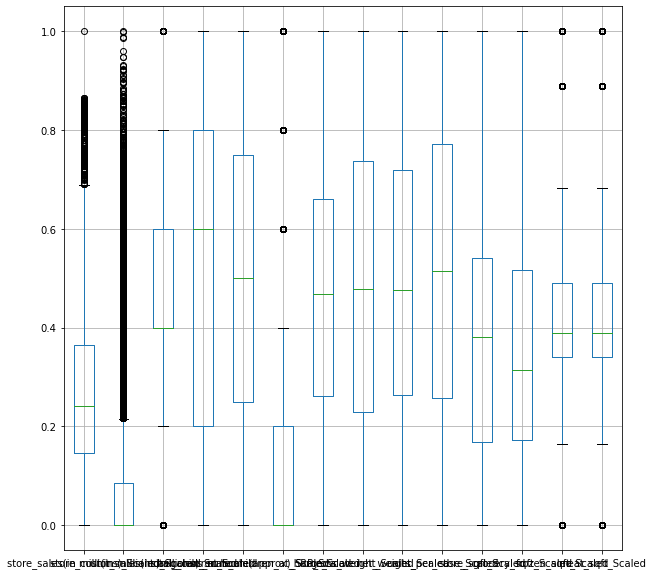

In [24]:
#boxplot das variaveis numericas
data = dfnum2.sample(False, 0.8).toPandas()
axs = pd.plotting.boxplot(data, figsize=(10, 10))
n = len(data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())
    
    # as 2 primeiras variaveis tem bastante outliers
    #mas se excluirmos, sera um valor grande de linhas

In [25]:
#verificando a ocorrencia das variaveis em ordem decrescente
dfnum2.groupBy("store_sales(in millions)_Scaled").count().orderBy('count', ascending=False).show(30)
dfnum2.groupBy("store_cost(in millions)_Scaled").count().orderBy('count', ascending=False).show(30)

+-------------------------------+-----+
|store_sales(in millions)_Scaled|count|
+-------------------------------+-----+
|                          0.332|  399|
|                          0.241|  344|
|                          0.183|  338|
|                          0.102|  325|
|                          0.224|  324|
|                          0.324|  314|
|                          0.202|  311|
|                           0.22|  300|
|                            0.3|  296|
|                          0.232|  294|
|                          0.286|  284|
|                          0.191|  284|
|                          0.199|  280|
|                          0.216|  278|
|                          0.308|  277|
|                          0.207|  273|
|                          0.218|  270|
|                          0.225|  269|
|                          0.372|  268|
|                          0.141|  262|
|                            0.1|  261|
|                          0.274|  261|


+------------------------------+-----+
|store_cost(in millions)_Scaled|count|
+------------------------------+-----+
|                           0.0|40752|
|                         0.001| 3302|
|                         0.159|  121|
|                         0.215|  113|
|                         0.128|   93|
|                         0.144|   92|
|                         0.247|   89|
|                         0.212|   89|
|                         0.181|   85|
|                         0.166|   84|
|                         0.207|   83|
|                         0.317|   80|
|                         0.163|   80|
|                         0.111|   77|
|                         0.225|   77|
|                         0.249|   76|
|                         0.291|   74|
|                         0.203|   73|
|                         0.121|   72|
|                         0.185|   72|
|                         0.326|   72|
|                         0.108|   71|
|                        

In [26]:
#dropando a variavel,com 40000 zeros
dfnum2=dfnum2.drop("store_cost(in millions)_Scaled")

In [27]:
#excluindo 1 porcento de cada faixa para tirar os outliers
df=dfnum2.toPandas()
#falta esta parte
q1=df["store_sales(in millions)_Scaled"].quantile(0.99)
q2=df["store_sales(in millions)_Scaled"].quantile(0.01)

In [28]:
print(q1)
print(q2)

0.679
0.031


In [29]:
df = df[(df["store_sales(in millions)_Scaled"] <= q1) & (df["store_sales(in millions)_Scaled"] >= q2)]

dfnum2=spark.createDataFrame(df) 

In [30]:
#normalizados os dados, vamos juntar tudo
df1=dfnum2.toPandas()
df2=dfcat2.toPandas()
df3=target.toPandas()

df=pd.concat([df1, df2,df3], axis=1, join='inner')

dffinal=spark.createDataFrame(df) 

22/11/15 01:42:18 WARN TaskSetManager: Stage 73 contains a task of very large size (1509 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 01:42:19 WARN TaskSetManager: Stage 74 contains a task of very large size (2720 KiB). The maximum recommended task size is 1000 KiB.


In [31]:
dffinal.toPandas()

22/11/15 01:42:21 WARN TaskSetManager: Stage 76 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


,store_sales(in millions)_Scaled,unit_sales(in millions)_Scaled,total_children_Scaled,avg_cars_at home(approx)_Scaled,num_children_at_home_Scaled,SRP_Scaled,gross_weight_Scaled,net_weight_Scaled,units_per_case_Scaled,store_sqft_Scaled,...,education1,member_card1,occupation1,houseowner1,brand_name1,store_type1,store_city1,store_state1,media_type1,cost
0,0.306,0.6,0.2,0.25,0.2,0.385,0.862,0.825,0.457,0.381,...,0.0,1.0,1.0,0.0,12.0,1.0,1.0,1.0,0.0,126.62
1,0.224,0.4,0.0,1.00,0.0,0.385,0.862,0.825,0.457,0.381,...,2.0,3.0,0.0,0.0,12.0,1.0,1.0,1.0,0.0,59.86
2,0.141,0.2,0.8,0.25,0.0,0.385,0.862,0.825,0.457,0.381,...,0.0,1.0,2.0,1.0,12.0,1.0,1.0,1.0,0.0,84.16
3,0.141,0.2,0.4,0.50,0.4,0.385,0.862,0.825,0.457,0.381,...,1.0,0.0,2.0,0.0,12.0,1.0,1.0,1.0,7.0,95.78
4,0.159,0.4,0.0,0.50,0.0,0.247,0.070,0.116,0.800,0.381,...,0.0,0.0,1.0,1.0,16.0,1.0,1.0,1.0,5.0,50.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59246,0.100,0.0,0.2,0.25,0.2,0.649,0.855,0.876,0.714,0.111,...,1.0,0.0,1.0,0.0,32.0,1.0,10.0,5.0,12.0,77.24
59247,0.049,0.0,0.4,0.50,0.0,0.316,0.717,0.690,1.000,0.111,...,0.0,0.0,1.0,0.0,34.0,1.0,10.0,5.0,6.0,138.18
59248,0.224,0.2,0.2,0.75,0.0,0.649,0.855,0.876,0.714,0.111,...,1.0,3.0,3.0,0.0,31.0,1.0,10.0,5.0,4.0,144.54
59249,0.347,0.4,0.4,1.00,0.0,0.649,0.855,0.876,0.714,0.729,...,2.0,0.0,0.0,1.0,31.0,1.0,10.0,5.0,7.0,75.22


22/11/15 01:42:23 WARN TaskSetManager: Stage 77 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


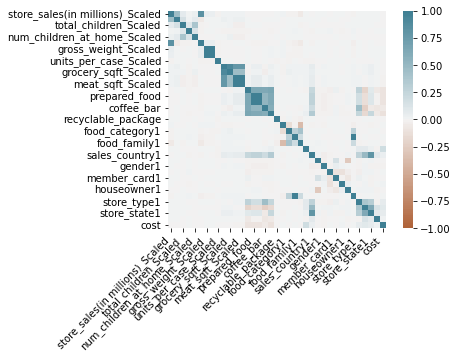

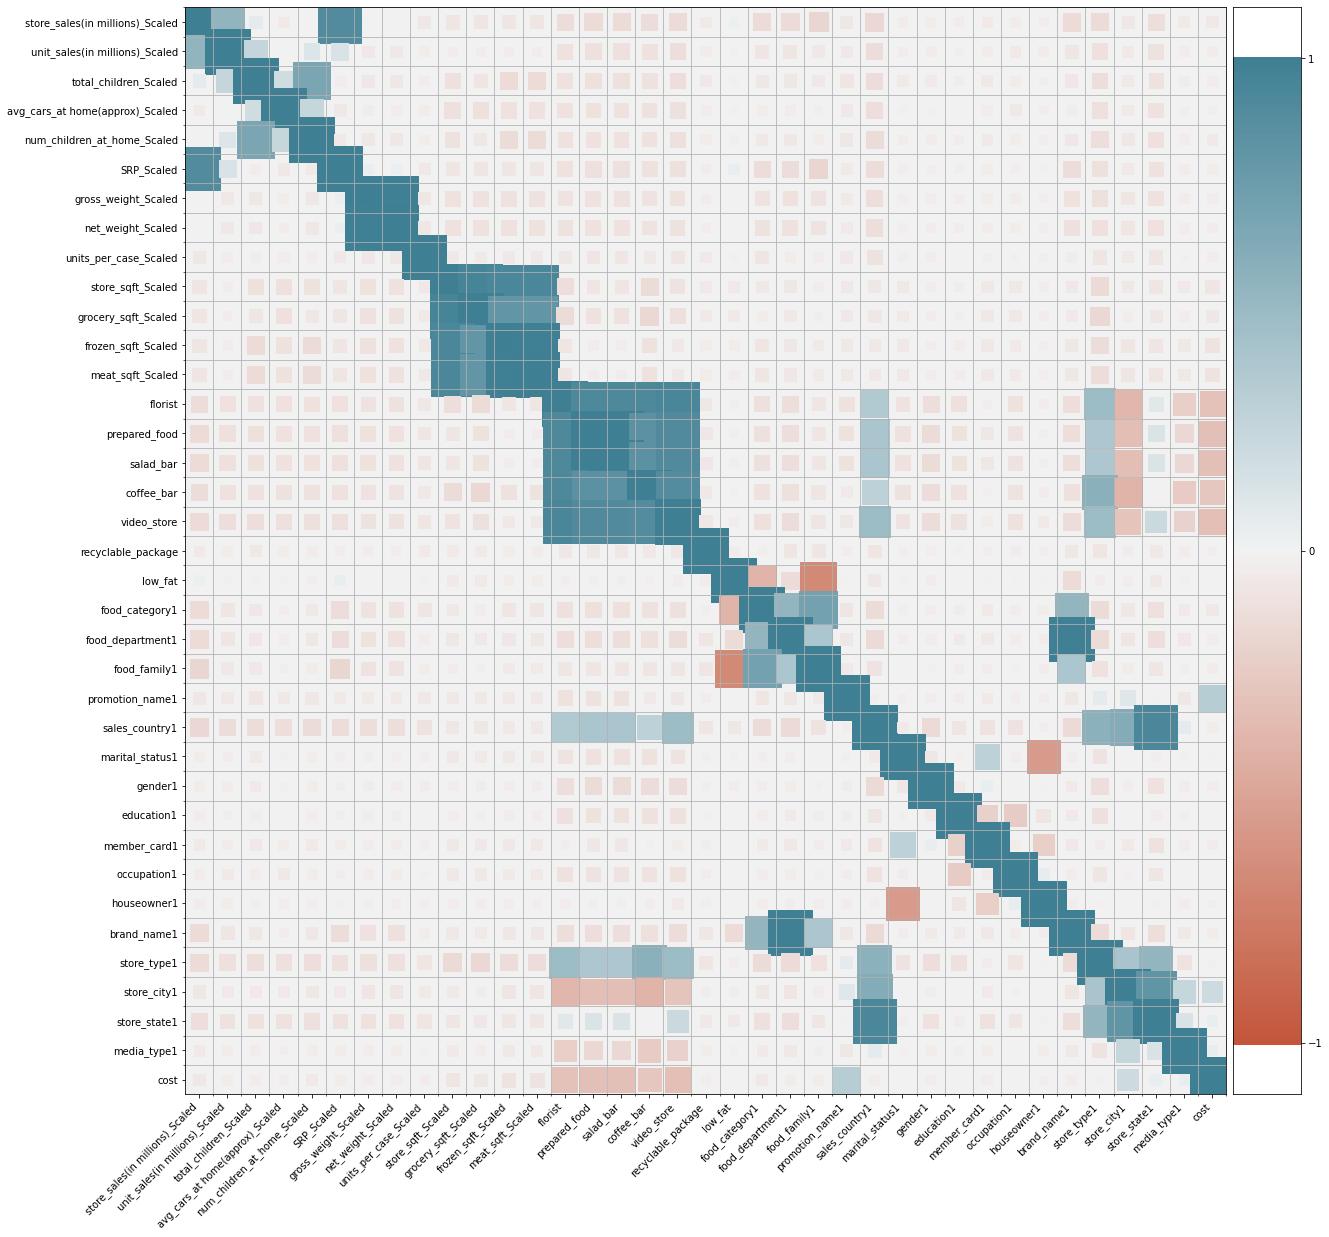

In [32]:
#!pip install heatmapz
#mapa de correlacao
from heatmap import heatmap, corrplot
import seaborn as sns


corr = dffinal.toPandas()
corr = corr.corr()

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(30, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

plt.figure(figsize=(20, 20))
corrplot(corr.corr(), size_scale=2000);

22/11/15 01:42:28 WARN TaskSetManager: Stage 78 contains a task of very large size (1509 KiB). The maximum recommended task size is 1000 KiB.


IndexError: index 12 is out of bounds for axis 0 with size 4

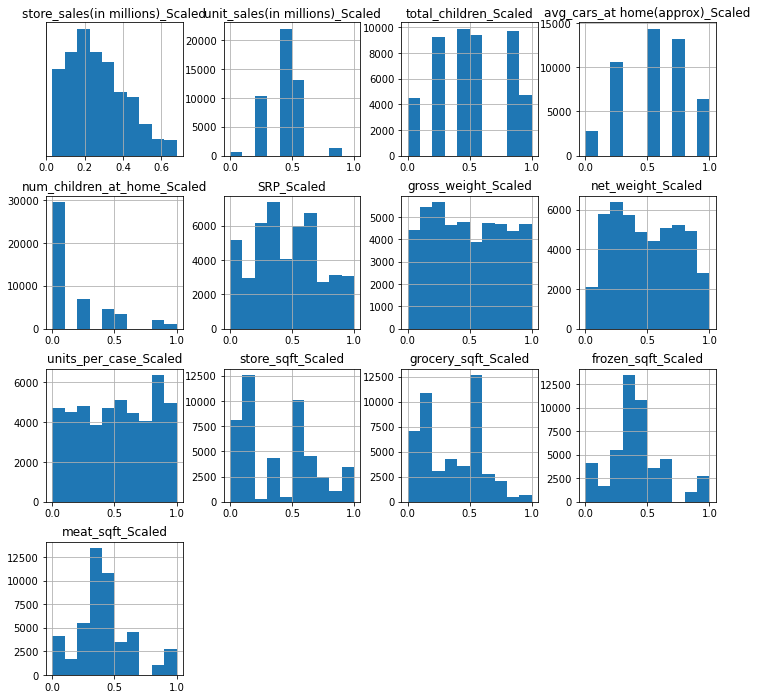

In [33]:
#histograma das variaveis numericas
data = dfnum2.sample(False, 0.8).toPandas()
axs = pd.plotting.hist_frame(data, figsize=(12, 12))
n = len(data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [61]:
#Vamos vetorizar para passar o modelo
vetor = VectorAssembler(inputCols = [*[cols for cols in dffinal.columns]], outputCol = "features")
df = vetor.transform(dffinal)
df = df.select(["features", "cost"])
df.show(3)

22/11/15 02:00:28 WARN TaskSetManager: Stage 278 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
+--------------------+------+
|            features|  cost|
+--------------------+------+
|[0.306,0.6,0.2,0....|126.62|
|[0.224,0.4,0.0,1....| 59.86|
|[0.141,0.2,0.8,0....| 84.16|
+--------------------+------+
only showing top 3 rows



In [62]:
#separando em treino e teste
splits = df.randomSplit([0.7, 0.3])
treino = splits[0]
teste= splits[1]

<h2>modelo de regressao linear</h2>

In [36]:
#treinando modelo de regressao linear
lr = LinearRegression(featuresCol = 'features', labelCol='cost', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(treino)
print("coeficientes: " + str(lr_model.coefficients))
print("intercepto: " + str(lr_model.intercept))

22/11/15 01:42:48 WARN TaskSetManager: Stage 80 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 01:42:51 WARN TaskSetManager: Stage 81 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


coeficientes: [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.9900266384005865]
intercepto: 0.9901271299555691


In [38]:
#avaliacao
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 0.299402
r2: 0.999901


<h2>random forest</h2>

In [142]:
from pyspark.ml.regression import RandomForestRegressor
rf = RandomForestRegressor(labelCol="cost", featuresCol="features")
modelo=rf.fit(treino)

22/11/15 02:50:51 WARN TaskSetManager: Stage 3273 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:50:51 WARN TaskSetManager: Stage 3274 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:50:52 WARN TaskSetManager: Stage 3275 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:50:53 WARN TaskSetManager: Stage 3277 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:50:54 WARN TaskSetManager: Stage 3279 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:50:54 WARN TaskSetManager: Stage 3281 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:50:55 WARN TaskSetManager: Stage 3283 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:50:56 WARN TaskSetManager: Stage 3285 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


In [146]:
avaliador = RegressionEvaluator(predictionCol="prediction", labelCol="cost", metricName="r2")

In [147]:
previsao=modelo.transform(teste)

In [148]:
print('R2:', avaliador.evaluate(previsao))

22/11/15 02:56:25 WARN TaskSetManager: Stage 3287 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


R2: 0.9649465978208528


In [118]:
#usando o grid builder para tunar os hyperparametros
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

parametros = (ParamGridBuilder()
               .addGrid(rf.maxDepth, [5, 8, 10])
               .addGrid(rf.maxBins, [10, 50, 100])
               .addGrid(rf.numTrees, [5, 10, 20])
             .build())

In [121]:
#fazendo a cross validation com 5 folds
cross = CrossValidator(estimator = rf,
                      estimatorParamMaps = parametros,
                      evaluator = avaliador,
                      numFolds = 5)

In [123]:
modelos_cross = cross.fit(treino)

22/11/15 02:30:45 WARN TaskSetManager: Stage 502 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:30:46 WARN TaskSetManager: Stage 503 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:30:47 WARN TaskSetManager: Stage 504 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:30:47 WARN TaskSetManager: Stage 506 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:30:48 WARN TaskSetManager: Stage 508 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:30:48 WARN TaskSetManager: Stage 510 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:30:48 WARN TaskSetManager: Stage 512 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:30:48 WARN TaskSetManager: Stage 514 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:30:49 WARN TaskSetManager: Stage 516 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.

22/11/15 02:30:50 WARN TaskSetManager: Stage 517 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:30:50 WARN TaskSetManager: Stage 518 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:30:50 WARN TaskSetManager: Stage 519 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:30:51 WARN TaskSetManager: Stage 521 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:30:51 WARN TaskSetManager: Stage 523 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:30:51 WARN TaskSetManager: Stage 525 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:30:52 WARN TaskSetManager: Stage 527 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.

22/11/15 02:30:54 WARN TaskSetManager: Stage 538 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:30:54 WARN TaskSetManager: Stage 540 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:30:55 WARN TaskSetManager: Stage 542 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:30:55 WARN TaskSetManager: Stage 544 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:30:56 WARN TaskSetManager: Stage 546 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:30:56 WARN TaskSetManager: Stage 547 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:30:56 WARN TaskSetManager: Stage 548 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.

22/11/15 02:31:12 WARN TaskSetManager: Stage 636 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:31:13 WARN TaskSetManager: Stage 637 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:31:13 WARN TaskSetManager: Stage 638 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:31:13 WARN TaskSetManager: Stage 639 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:31:13 WARN TaskSetManager: Stage 641 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:31:13 WARN TaskSetManager: Stage 643 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:31:14 WARN TaskSetManager: Stage 645 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.

22/11/15 02:31:24 WARN TaskSetManager: Stage 697 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:31:25 WARN TaskSetManager: Stage 699 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:31:25 WARN TaskSetManager: Stage 700 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:31:25 WARN TaskSetManager: Stage 701 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:31:26 WARN TaskSetManager: Stage 702 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:31:26 WARN TaskSetManager: Stage 704 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:31:26 WARN TaskSetManager: Stage 706 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:31:26 WARN TaskSetManager: Stage 708 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.

22/11/15 02:31:37 WARN TaskSetManager: Stage 760 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:31:39 WARN TaskSetManager: Stage 762 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:31:39 WARN TaskSetManager: Stage 763 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:31:39 WARN TaskSetManager: Stage 764 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:31:39 WARN TaskSetManager: Stage 765 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:31:40 WARN TaskSetManager: Stage 767 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:31:40 WARN TaskSetManager: Stage 769 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:31:40 WARN TaskSetManager: Stage 771 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.

22/11/15 02:31:52 WARN TaskSetManager: Stage 823 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:31:54 WARN TaskSetManager: Stage 825 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:31:54 WARN TaskSetManager: Stage 826 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:31:54 WARN TaskSetManager: Stage 827 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:31:54 WARN TaskSetManager: Stage 828 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:31:55 WARN TaskSetManager: Stage 830 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:31:55 WARN TaskSetManager: Stage 832 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:31:55 WARN TaskSetManager: Stage 834 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.

22/11/15 02:32:04 WARN TaskSetManager: Stage 875 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:32:04 WARN TaskSetManager: Stage 876 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:32:05 WARN TaskSetManager: Stage 877 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:32:05 WARN TaskSetManager: Stage 878 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:32:05 WARN TaskSetManager: Stage 880 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:32:06 WARN TaskSetManager: Stage 882 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:32:06 WARN TaskSetManager: Stage 884 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.

22/11/15 02:32:08 WARN TaskSetManager: Stage 894 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:32:10 WARN DAGScheduler: Broadcasting large task binary with size 1433.2 KiB
22/11/15 02:32:10 WARN TaskSetManager: Stage 896 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:32:11 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/11/15 02:32:11 WARN TaskSetManager: Stage 898 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:32:13 WARN TaskSetManager: Stage 900 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:32:14 WARN TaskSetManager: Stage 901 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:32:14 WARN TaskSetManager: Stage 902 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:32:14 WARN TaskSetManager: Stage 903 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:32:14 WARN TaskSetManager: Stage 905 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:32:15 WARN TaskSetManager: Stage 907 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:32:15 WARN TaskSetManager: Stage 909 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:32:15 WARN TaskSetManager: Stage 911 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:32:15 WARN TaskSetManager: Stage 913 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:32:15 WARN TaskSetManager: Stage 915 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:32:16 WARN TaskSetManager: Stage 917 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:32:16 WARN TaskSetManager: Stage 919 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.

22/11/15 02:32:22 WARN TaskSetManager: Stage 944 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:32:23 WARN TaskSetManager: Stage 946 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:32:24 WARN DAGScheduler: Broadcasting large task binary with size 1184.6 KiB
22/11/15 02:32:24 WARN TaskSetManager: Stage 948 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:32:25 WARN TaskSetManager: Stage 950 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:32:25 WARN TaskSetManager: Stage 951 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:32:25 WARN TaskSetManager: Stage 952 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:32:25 WARN TaskSetManager: Stage 953 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:32:26 WARN TaskSetManager: Stage 955 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:32:26 WARN TaskSetManager: Stage 957 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:32:27 WARN TaskSetManager: Stage 959 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:32:27 WARN TaskSetManager: Stage 961 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:32:27 WARN TaskSetManager: Stage 963 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:32:28 WARN TaskSetManager: Stage 965 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:32:29 WARN TaskSetManager: Stage 967 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:32:30 WARN TaskSetManager: Stage 969 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.

22/11/15 02:32:31 WARN DAGScheduler: Broadcasting large task binary with size 1448.8 KiB
22/11/15 02:32:31 WARN TaskSetManager: Stage 971 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:32:33 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/11/15 02:32:33 WARN TaskSetManager: Stage 973 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:32:36 WARN TaskSetManager: Stage 975 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:32:36 WARN TaskSetManager: Stage 976 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:32:36 WARN TaskSetManager: Stage 977 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:32:36 WARN TaskSetManager: Stage 978 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:32:36 WARN TaskSetManager: Stage 980 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:32:37 WARN TaskSetManager: Stage 982 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:32:37 WARN TaskSetManager: Stage 984 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.

22/11/15 02:32:46 WARN DAGScheduler: Broadcasting large task binary with size 1159.9 KiB
22/11/15 02:32:46 WARN TaskSetManager: Stage 1023 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:32:48 WARN TaskSetManager: Stage 1025 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:32:48 WARN TaskSetManager: Stage 1026 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:32:48 WARN TaskSetManager: Stage 1027 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:32:48 WARN TaskSetManager: Stage 1028 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:32:48 WARN TaskSetManager: Stage 1030 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:32:49 WARN TaskSetManager: Stage 1032 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:32:49 WARN TaskSetManager: Stage 1034 contains a task of very large size (4288 KiB). The maximum recommended task size is 10

22/11/15 02:32:54 WARN DAGScheduler: Broadcasting large task binary with size 1474.2 KiB
22/11/15 02:32:54 WARN TaskSetManager: Stage 1046 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:32:56 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/11/15 02:32:56 WARN TaskSetManager: Stage 1048 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:32:59 WARN TaskSetManager: Stage 1050 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:33:00 WARN TaskSetManager: Stage 1051 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:33:00 WARN TaskSetManager: Stage 1052 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:33:01 WARN TaskSetManager: Stage 1053 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:33:01 WARN TaskSetManager: Stage 1055 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:33:01 WARN TaskSetManager: Stage 1057 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:33:02 WARN TaskSetManager: Stage 1059 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:33:02 WARN TaskSetManager: Stage 1061 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:33:02 WARN TaskSetManager: Stage 1063 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:33:02 WARN TaskSetManager: Stage 1065 contains a task of very large size (4288 KiB). The maximum recommended task size is 10

22/11/15 02:33:18 WARN TaskSetManager: Stage 1151 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:33:19 WARN TaskSetManager: Stage 1153 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:33:19 WARN TaskSetManager: Stage 1155 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:33:19 WARN TaskSetManager: Stage 1156 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:33:19 WARN TaskSetManager: Stage 1157 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:33:19 WARN TaskSetManager: Stage 1158 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:33:20 WARN TaskSetManager: Stage 1160 contains a task of very large size (4288 KiB). The maximum recommended task size is 10

22/11/15 02:33:36 WARN TaskSetManager: Stage 1246 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:33:37 WARN TaskSetManager: Stage 1248 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:33:37 WARN TaskSetManager: Stage 1249 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:33:37 WARN TaskSetManager: Stage 1250 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:33:37 WARN TaskSetManager: Stage 1251 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:33:38 WARN TaskSetManager: Stage 1253 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:33:38 WARN TaskSetManager: Stage 1255 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:33:38 WARN TaskSetManager: Stage 1257 contains a task of very large size (4288 KiB). The maximum recommended task size is 10

22/11/15 02:33:49 WARN TaskSetManager: Stage 1309 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:33:50 WARN TaskSetManager: Stage 1311 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:33:51 WARN TaskSetManager: Stage 1312 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:33:51 WARN TaskSetManager: Stage 1313 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:33:51 WARN TaskSetManager: Stage 1314 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:33:51 WARN TaskSetManager: Stage 1316 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:33:52 WARN TaskSetManager: Stage 1318 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:33:52 WARN TaskSetManager: Stage 1320 contains a task of very large size (4288 KiB). The maximum recommended task size is 10

22/11/15 02:34:01 WARN TaskSetManager: Stage 1370 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:34:02 WARN TaskSetManager: Stage 1372 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:34:04 WARN TaskSetManager: Stage 1374 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:34:04 WARN TaskSetManager: Stage 1375 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:34:04 WARN TaskSetManager: Stage 1376 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:34:04 WARN TaskSetManager: Stage 1377 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:34:04 WARN TaskSetManager: Stage 1379 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:34:05 WARN TaskSetManager: Stage 1381 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:34:05 WARN TaskSetManager: Stage 1383 contains a task of very large size (4288 KiB). The maximum recommended task size is 10

22/11/15 02:34:18 WARN TaskSetManager: Stage 1443 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:34:19 WARN DAGScheduler: Broadcasting large task binary with size 1448.2 KiB
22/11/15 02:34:19 WARN TaskSetManager: Stage 1445 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:34:21 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/11/15 02:34:21 WARN TaskSetManager: Stage 1447 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:34:23 WARN TaskSetManager: Stage 1449 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:34:23 WARN TaskSetManager: Stage 1450 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:34:23 WARN TaskSetManager: Stage 1451 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:34:23 WARN TaskSetManager: Stage 1452 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:34:23 WARN TaskSetManager: Stage 1454 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:34:24 WARN TaskSetManager: Stage 1456 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:34:24 WARN TaskSetManager: Stage 1458 contains a task of very large size (4288 KiB). The maximum recommended task size is 10

22/11/15 02:34:40 WARN DAGScheduler: Broadcasting large task binary with size 1453.1 KiB
22/11/15 02:34:40 WARN TaskSetManager: Stage 1520 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:34:42 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/11/15 02:34:42 WARN TaskSetManager: Stage 1522 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:34:45 WARN TaskSetManager: Stage 1524 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:34:45 WARN TaskSetManager: Stage 1525 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:34:45 WARN TaskSetManager: Stage 1526 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:34:45 WARN TaskSetManager: Stage 1527 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:34:45 WARN TaskSetManager: Stage 1529 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:34:46 WARN TaskSetManager: Stage 1531 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:34:46 WARN TaskSetManager: Stage 1533 contains a task of very large size (4288 KiB). The maximum recommended task size is 10

22/11/15 02:34:54 WARN TaskSetManager: Stage 1570 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:34:55 WARN DAGScheduler: Broadcasting large task binary with size 1172.4 KiB
22/11/15 02:34:55 WARN TaskSetManager: Stage 1572 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:34:56 WARN TaskSetManager: Stage 1574 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:34:57 WARN TaskSetManager: Stage 1575 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:34:57 WARN TaskSetManager: Stage 1576 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:34:57 WARN TaskSetManager: Stage 1577 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:34:57 WARN TaskSetManager: Stage 15

22/11/15 02:35:01 WARN TaskSetManager: Stage 1593 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:35:03 WARN DAGScheduler: Broadcasting large task binary with size 1469.1 KiB
22/11/15 02:35:03 WARN TaskSetManager: Stage 1595 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:35:05 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/11/15 02:35:05 WARN TaskSetManager: Stage 1597 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:35:08 WARN TaskSetManager: Stage 1599 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:35:09 WARN TaskSetManager: Stage 1600 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:35:09 WARN TaskSetManager: Stage 1601 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:35:10 WARN TaskSetManager: Stage 1602 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:35:10 WARN TaskSetManager: Stage 1604 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:35:10 WARN TaskSetManager: Stage 1606 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:35:11 WARN TaskSetManager: Stage 1608 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:35:11 WARN TaskSetManager: Stage 1610 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:35:11 WARN TaskSetManager: Stage 1612 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:35:11 WARN TaskSetManager: Stage 1614 contains a task of very large size (4288 KiB). The maximum recommended task size is 10

22/11/15 02:35:12 WARN TaskSetManager: Stage 1615 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:35:12 WARN TaskSetManager: Stage 1616 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:35:12 WARN TaskSetManager: Stage 1617 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:35:13 WARN TaskSetManager: Stage 1619 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:35:13 WARN TaskSetManager: Stage 1621 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:35:13 WARN TaskSetManager: Stage 1623 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:35:14 WARN TaskSetManager: Stage 1625 contains a task of very large size (4288 KiB). The maximum recommended task size is 10

22/11/15 02:35:27 WARN TaskSetManager: Stage 1709 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:35:27 WARN TaskSetManager: Stage 1711 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:35:27 WARN TaskSetManager: Stage 1713 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:35:28 WARN TaskSetManager: Stage 1715 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:35:28 WARN TaskSetManager: Stage 1717 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:35:28 WARN TaskSetManager: Stage 1719 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:35:29 WARN TaskSetManager: Stage 1720 contains a task of very large size (4288 KiB). The maximum recommended task size is 10

22/11/15 02:35:43 WARN TaskSetManager: Stage 1797 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:35:43 WARN TaskSetManager: Stage 1798 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:35:43 WARN TaskSetManager: Stage 1799 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:35:43 WARN TaskSetManager: Stage 1800 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:35:44 WARN TaskSetManager: Stage 1802 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:35:44 WARN TaskSetManager: Stage 1804 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:35:44 WARN TaskSetManager: Stage 1806 contains a task of very large size (4288 KiB). The maximum recommended task size is 10

22/11/15 02:35:54 WARN TaskSetManager: Stage 1858 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:35:56 WARN TaskSetManager: Stage 1860 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:35:56 WARN TaskSetManager: Stage 1861 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:35:56 WARN TaskSetManager: Stage 1862 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:35:56 WARN TaskSetManager: Stage 1863 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:35:56 WARN TaskSetManager: Stage 1865 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:35:57 WARN TaskSetManager: Stage 1867 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:35:57 WARN TaskSetManager: Stage 1869 contains a task of very large size (4288 KiB). The maximum recommended task size is 10

22/11/15 02:36:03 WARN TaskSetManager: Stage 1902 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:36:04 WARN TaskSetManager: Stage 1903 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:36:04 WARN TaskSetManager: Stage 1904 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:36:04 WARN TaskSetManager: Stage 1905 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:36:04 WARN TaskSetManager: Stage 1907 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:36:05 WARN TaskSetManager: Stage 1909 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:36:05 WARN TaskSetManager: Stage 1911 contains a task of very large size (4288 KiB). The maximum recommended task size is 10

22/11/15 02:36:07 WARN TaskSetManager: Stage 1919 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:36:09 WARN TaskSetManager: Stage 1921 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:36:10 WARN TaskSetManager: Stage 1923 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:36:11 WARN TaskSetManager: Stage 1924 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:36:11 WARN TaskSetManager: Stage 1925 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:36:11 WARN TaskSetManager: Stage 1926 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:36:11 WARN TaskSetManager: Stage 1928 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:36:12 WARN TaskSetManager: Stage 1930 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:36:12 WARN TaskSetManager: Stage 1932 contains a task of very large size (4288 KiB). The maximum recommended task size is 10

22/11/15 02:36:25 WARN DAGScheduler: Broadcasting large task binary with size 1446.2 KiB
22/11/15 02:36:25 WARN TaskSetManager: Stage 1994 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:36:27 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/11/15 02:36:27 WARN TaskSetManager: Stage 1996 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:36:29 WARN TaskSetManager: Stage 1998 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:36:29 WARN TaskSetManager: Stage 1999 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:36:29 WARN TaskSetManager: Stage 2000 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:36:29 WARN TaskSetManager: Stage 2001 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:36:30 WARN TaskSetManager: Stage 2003 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:36:30 WARN TaskSetManager: Stage 2005 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:36:30 WARN TaskSetManager: Stage 2007 contains a task of very large size (4288 KiB). The maximum recommended task size is 10

22/11/15 02:36:39 WARN TaskSetManager: Stage 2048 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:36:39 WARN TaskSetManager: Stage 2049 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:36:39 WARN TaskSetManager: Stage 2050 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:36:39 WARN TaskSetManager: Stage 2051 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:36:40 WARN TaskSetManager: Stage 2053 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:36:40 WARN TaskSetManager: Stage 2055 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:36:41 WARN TaskSetManager: Stage 2057 contains a task of very large size (4288 KiB). The maximum recommended task size is 10

22/11/15 02:36:44 WARN TaskSetManager: Stage 2067 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:36:45 WARN DAGScheduler: Broadcasting large task binary with size 1467.7 KiB
22/11/15 02:36:45 WARN TaskSetManager: Stage 2069 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:36:47 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/11/15 02:36:47 WARN TaskSetManager: Stage 2071 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:36:50 WARN TaskSetManager: Stage 2073 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:36:51 WARN TaskSetManager: Stage 2074 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:36:51 WARN TaskSetManager: Stage 2075 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:36:51 WARN TaskSetManager: Stage 2076 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:36:51 WARN TaskSetManager: Stage 2078 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:36:51 WARN TaskSetManager: Stage 2080 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:36:52 WARN TaskSetManager: Stage 2082 contains a task of very large size (4288 KiB). The maximum recommended task size is 10

22/11/15 02:37:01 WARN DAGScheduler: Broadcasting large task binary with size 1168.1 KiB
22/11/15 02:37:01 WARN TaskSetManager: Stage 2121 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:37:02 WARN TaskSetManager: Stage 2123 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:37:03 WARN TaskSetManager: Stage 2124 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:37:03 WARN TaskSetManager: Stage 2125 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:37:03 WARN TaskSetManager: Stage 2126 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:37:03 WARN TaskSetManager: Stage 2128 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:37:03 WARN TaskSetManager: Stage 2130 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:37:04 WARN TaskSetManager: Stage 2132 contains a task of very large size (4288 KiB). The maximum recommended task size is 10

22/11/15 02:37:06 WARN TaskSetManager: Stage 2140 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:37:07 WARN TaskSetManager: Stage 2142 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:37:09 WARN DAGScheduler: Broadcasting large task binary with size 1470.9 KiB
22/11/15 02:37:09 WARN TaskSetManager: Stage 2144 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:37:11 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/11/15 02:37:11 WARN TaskSetManager: Stage 2146 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:37:14 WARN TaskSetManager: Stage 2148 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:37:15 WARN TaskSetManager: Stage 2149 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:37:15 WARN TaskSetManager: Stage 2150 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:37:16 WARN TaskSetManager: Stage 2151 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:37:16 WARN TaskSetManager: Stage 2153 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:37:16 WARN TaskSetManager: Stage 2155 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:37:16 WARN TaskSetManager: Stage 2157 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:37:17 WARN TaskSetManager: Stage 2159 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:37:17 WARN TaskSetManager: Stage 2161 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:37:17 WARN TaskSetManager: Stage 2163 contains a task of very large size (4288 KiB). The maximum recommended task size is 10

22/11/15 02:37:33 WARN TaskSetManager: Stage 2249 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:37:33 WARN TaskSetManager: Stage 2251 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:37:33 WARN TaskSetManager: Stage 2253 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:37:34 WARN TaskSetManager: Stage 2254 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:37:34 WARN TaskSetManager: Stage 2255 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:37:34 WARN TaskSetManager: Stage 2256 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:37:34 WARN TaskSetManager: Stage 2258 contains a task of very large size (4288 KiB). The maximum recommended task size is 10

22/11/15 02:37:51 WARN TaskSetManager: Stage 2346 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:37:51 WARN TaskSetManager: Stage 2347 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:37:51 WARN TaskSetManager: Stage 2348 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:37:51 WARN TaskSetManager: Stage 2349 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:37:51 WARN TaskSetManager: Stage 2351 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:37:52 WARN TaskSetManager: Stage 2353 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:37:52 WARN TaskSetManager: Stage 2355 contains a task of very large size (4288 KiB). The maximum recommended task size is 10

22/11/15 02:38:01 WARN TaskSetManager: Stage 2407 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:38:03 WARN TaskSetManager: Stage 2409 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:38:03 WARN TaskSetManager: Stage 2410 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:38:03 WARN TaskSetManager: Stage 2411 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:38:03 WARN TaskSetManager: Stage 2412 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:38:04 WARN TaskSetManager: Stage 2414 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:38:04 WARN TaskSetManager: Stage 2416 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:38:04 WARN TaskSetManager: Stage 2418 contains a task of very large size (4288 KiB). The maximum recommended task size is 10

22/11/15 02:38:14 WARN TaskSetManager: Stage 2470 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:38:16 WARN TaskSetManager: Stage 2472 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:38:16 WARN TaskSetManager: Stage 2473 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:38:16 WARN TaskSetManager: Stage 2474 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:38:16 WARN TaskSetManager: Stage 2475 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:38:17 WARN TaskSetManager: Stage 2477 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:38:17 WARN TaskSetManager: Stage 2479 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:38:17 WARN TaskSetManager: Stage 2481 contains a task of very large size (4288 KiB). The maximum recommended task size is 10

22/11/15 02:38:25 WARN TaskSetManager: Stage 2522 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:38:25 WARN TaskSetManager: Stage 2523 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:38:25 WARN TaskSetManager: Stage 2524 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:38:25 WARN TaskSetManager: Stage 2525 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:38:26 WARN TaskSetManager: Stage 2527 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:38:26 WARN TaskSetManager: Stage 2529 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:38:26 WARN TaskSetManager: Stage 2531 contains a task of very large size (4288 KiB). The maximum recommended task size is 10

22/11/15 02:38:31 WARN DAGScheduler: Broadcasting large task binary with size 1449.9 KiB
22/11/15 02:38:31 WARN TaskSetManager: Stage 2543 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:38:33 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/11/15 02:38:33 WARN TaskSetManager: Stage 2545 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:38:35 WARN TaskSetManager: Stage 2547 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:38:35 WARN TaskSetManager: Stage 2548 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:38:35 WARN TaskSetManager: Stage 2549 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:38:35 WARN TaskSetManager: Stage 2550 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:38:36 WARN TaskSetManager: Stage 2552 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:38:36 WARN TaskSetManager: Stage 2554 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:38:36 WARN TaskSetManager: Stage 2556 contains a task of very large size (4288 KiB). The maximum recommended task size is 10

22/11/15 02:38:45 WARN DAGScheduler: Broadcasting large task binary with size 1198.6 KiB
22/11/15 02:38:45 WARN TaskSetManager: Stage 2595 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:38:47 WARN TaskSetManager: Stage 2597 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:38:47 WARN TaskSetManager: Stage 2598 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:38:47 WARN TaskSetManager: Stage 2599 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:38:47 WARN TaskSetManager: Stage 2600 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:38:48 WARN TaskSetManager: Stage 2602 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:38:48 WARN TaskSetManager: Stage 2604 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:38:48 WARN TaskSetManager: Stage 2606 contains a task of very large size (4288 KiB). The maximum recommended task size is 10

22/11/15 02:38:53 WARN DAGScheduler: Broadcasting large task binary with size 1453.9 KiB
22/11/15 02:38:53 WARN TaskSetManager: Stage 2618 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:38:55 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/11/15 02:38:55 WARN TaskSetManager: Stage 2620 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:38:57 WARN TaskSetManager: Stage 2622 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:38:57 WARN TaskSetManager: Stage 2623 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:38:57 WARN TaskSetManager: Stage 2624 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:38:57 WARN TaskSetManager: Stage 2625 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:38:58 WARN TaskSetManager: Stage 2627 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:38:58 WARN TaskSetManager: Stage 2629 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:38:58 WARN TaskSetManager: Stage 2631 contains a task of very large size (4288 KiB). The maximum recommended task size is 10

22/11/15 02:39:08 WARN TaskSetManager: Stage 2672 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:39:08 WARN TaskSetManager: Stage 2673 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:39:08 WARN TaskSetManager: Stage 2674 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:39:08 WARN TaskSetManager: Stage 2675 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:39:09 WARN TaskSetManager: Stage 2677 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:39:09 WARN TaskSetManager: Stage 2679 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:39:09 WARN TaskSetManager: Stage 2681 contains a task of very large size (4288 KiB). The maximum recommended task size is 10

22/11/15 02:39:11 WARN TaskSetManager: Stage 2689 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:39:13 WARN TaskSetManager: Stage 2691 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:39:15 WARN DAGScheduler: Broadcasting large task binary with size 1456.2 KiB
22/11/15 02:39:15 WARN TaskSetManager: Stage 2693 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:39:17 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/11/15 02:39:17 WARN TaskSetManager: Stage 2695 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:39:21 WARN TaskSetManager: Stage 2697 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:39:21 WARN TaskSetManager: Stage 2698 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:39:22 WARN TaskSetManager: Stage 2699 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:39:22 WARN TaskSetManager: Stage 2700 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:39:23 WARN TaskSetManager: Stage 2702 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:39:23 WARN TaskSetManager: Stage 2704 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:39:23 WARN TaskSetManager: Stage 2706 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:39:23 WARN TaskSetManager: Stage 2708 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:39:24 WARN TaskSetManager: Stage 2710 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:39:24 WARN TaskSetManager: Stage 2712 contains a task of very large size (4288 KiB). The maximum recommended task size is 10

22/11/15 02:39:25 WARN TaskSetManager: Stage 2713 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:39:25 WARN TaskSetManager: Stage 2714 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:39:25 WARN TaskSetManager: Stage 2715 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:39:25 WARN TaskSetManager: Stage 2717 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:39:26 WARN TaskSetManager: Stage 2719 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:39:26 WARN TaskSetManager: Stage 2721 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:39:26 WARN TaskSetManager: Stage 2723 contains a task of very large size (4288 KiB). The maximum recommended task size is 10

22/11/15 02:39:43 WARN TaskSetManager: Stage 2807 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:39:43 WARN TaskSetManager: Stage 2809 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:39:43 WARN TaskSetManager: Stage 2811 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:39:44 WARN TaskSetManager: Stage 2813 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:39:44 WARN TaskSetManager: Stage 2815 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:39:45 WARN TaskSetManager: Stage 2817 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:39:45 WARN TaskSetManager: Stage 2818 contains a task of very large size (4288 KiB). The maximum recommended task size is 10

22/11/15 02:39:46 WARN TaskSetManager: Stage 2824 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:39:46 WARN TaskSetManager: Stage 2826 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:39:47 WARN TaskSetManager: Stage 2828 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:39:47 WARN TaskSetManager: Stage 2830 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:39:48 WARN TaskSetManager: Stage 2832 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:39:49 WARN TaskSetManager: Stage 2833 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:39:49 WARN TaskSetManager: Stage 2834 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:39:49 WARN TaskSetManager: Stage 2835 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:39:49 WARN TaskSetManager: Stage 2837 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:39:50 WARN TaskSetManager: Stage 2839 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:39:50 WARN TaskSetManager: Stage 2841 contains a task of very large size (4288 KiB). The maximum recommended task size is 10

22/11/15 02:40:00 WARN TaskSetManager: Stage 2891 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:40:01 WARN TaskSetManager: Stage 2893 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:40:02 WARN TaskSetManager: Stage 2895 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:40:02 WARN TaskSetManager: Stage 2896 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:40:02 WARN TaskSetManager: Stage 2897 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:40:02 WARN TaskSetManager: Stage 2898 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:40:03 WARN TaskSetManager: Stage 2900 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:40:03 WARN TaskSetManager: Stage 2902 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:40:03 WARN TaskSetManager: Stage 2904 contains a task of very large size (4288 KiB). The maximum recommended task size is 10

22/11/15 02:40:12 WARN TaskSetManager: Stage 2954 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:40:13 WARN TaskSetManager: Stage 2956 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:40:15 WARN TaskSetManager: Stage 2958 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:40:15 WARN TaskSetManager: Stage 2959 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:40:15 WARN TaskSetManager: Stage 2960 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:40:15 WARN TaskSetManager: Stage 2961 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:40:15 WARN TaskSetManager: Stage 2963 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:40:16 WARN TaskSetManager: Stage 2965 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:40:16 WARN TaskSetManager: Stage 2967 contains a task of very large size (4288 KiB). The maximum recommended task size is 10

22/11/15 02:40:28 WARN TaskSetManager: Stage 3019 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:40:30 WARN TaskSetManager: Stage 3021 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:40:30 WARN TaskSetManager: Stage 3022 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:40:30 WARN TaskSetManager: Stage 3023 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:40:30 WARN TaskSetManager: Stage 3024 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:40:30 WARN TaskSetManager: Stage 3026 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:40:31 WARN TaskSetManager: Stage 3028 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:40:31 WARN TaskSetManager: Stage 3030 contains a task of very large size (4288 KiB). The maximum recommended task size is 10

22/11/15 02:40:39 WARN TaskSetManager: Stage 3071 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:40:40 WARN TaskSetManager: Stage 3072 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:40:40 WARN TaskSetManager: Stage 3073 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:40:40 WARN TaskSetManager: Stage 3074 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:40:40 WARN TaskSetManager: Stage 3076 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:40:41 WARN TaskSetManager: Stage 3078 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:40:41 WARN TaskSetManager: Stage 3080 contains a task of very large size (4288 KiB). The maximum recommended task size is 10

22/11/15 02:40:44 WARN TaskSetManager: Stage 3090 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:40:45 WARN DAGScheduler: Broadcasting large task binary with size 1488.5 KiB
22/11/15 02:40:45 WARN TaskSetManager: Stage 3092 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:40:46 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/11/15 02:40:46 WARN TaskSetManager: Stage 3094 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:40:48 WARN TaskSetManager: Stage 3096 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:40:48 WARN TaskSetManager: Stage 3097 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:40:48 WARN TaskSetManager: Stage 3098 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:40:49 WARN TaskSetManager: Stage 3099 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:40:49 WARN TaskSetManager: Stage 3101 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:40:49 WARN TaskSetManager: Stage 3103 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:40:49 WARN TaskSetManager: Stage 3105 contains a task of very large size (4288 KiB). The maximum recommended task size is 10

22/11/15 02:40:58 WARN TaskSetManager: Stage 3146 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:40:58 WARN TaskSetManager: Stage 3147 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:40:59 WARN TaskSetManager: Stage 3148 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:40:59 WARN TaskSetManager: Stage 3149 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:40:59 WARN TaskSetManager: Stage 3151 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:40:59 WARN TaskSetManager: Stage 3153 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:41:00 WARN TaskSetManager: Stage 3155 contains a task of very large size (4288 KiB). The maximum recommended task size is 10

22/11/15 02:41:04 WARN DAGScheduler: Broadcasting large task binary with size 1450.1 KiB
22/11/15 02:41:04 WARN TaskSetManager: Stage 3167 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:41:06 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/11/15 02:41:06 WARN TaskSetManager: Stage 3169 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:41:08 WARN TaskSetManager: Stage 3171 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:41:08 WARN TaskSetManager: Stage 3172 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:41:08 WARN TaskSetManager: Stage 3173 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:41:08 WARN TaskSetManager: Stage 3174 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:41:09 WARN TaskSetManager: Stage 3176 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:41:09 WARN TaskSetManager: Stage 3178 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:41:09 WARN TaskSetManager: Stage 3180 contains a task of very large size (4288 KiB). The maximum recommended task size is 10

22/11/15 02:41:19 WARN TaskSetManager: Stage 3221 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:41:20 WARN TaskSetManager: Stage 3222 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:41:20 WARN TaskSetManager: Stage 3223 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:41:20 WARN TaskSetManager: Stage 3224 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:41:20 WARN TaskSetManager: Stage 3226 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:41:21 WARN TaskSetManager: Stage 3228 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:41:21 WARN TaskSetManager: Stage 3230 contains a task of very large size (4288 KiB). The maximum recommended task size is 10

22/11/15 02:41:24 WARN TaskSetManager: Stage 3240 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:41:26 WARN DAGScheduler: Broadcasting large task binary with size 1477.2 KiB
22/11/15 02:41:26 WARN TaskSetManager: Stage 3242 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:41:28 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/11/15 02:41:28 WARN TaskSetManager: Stage 3244 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:41:31 WARN TaskSetManager: Stage 3246 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:41:31 WARN TaskSetManager: Stage 3247 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:41:31 WARN TaskSetManager: Stage 3248 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:41:32 WARN TaskSetManager: Stage 3249 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:41:32 WARN TaskSetManager: Stage 3251 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:41:33 WARN TaskSetManager: Stage 3253 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:41:33 WARN TaskSetManager: Stage 3255 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:41:34 WARN TaskSetManager: Stage 3257 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:41:34 WARN TaskSetManager: Stage 3259 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:41:35 WARN TaskSetManager: Stage 3261 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/15 02:41:35 WARN TaskSetManager: Stage 3263 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:41:36 WARN TaskSetManager: Stage 3265 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:41:38 WARN DAGScheduler: Broadcasting large task binary with size 1457.9 KiB
22/11/15 02:41:38 WARN TaskSetManager: Stage 3267 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 02:41:40 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/11/15 02:41:40 WARN TaskSetManager: Stage 3269 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


In [125]:
previsao_cross = modelos_cross.transform(teste)

In [128]:
avaliador_cross = RegressionEvaluator(predictionCol="prediction", labelCol="cost", metricName="r2")

In [129]:
print('R2:', avaliador_cross.evaluate(previsao_cross))

22/11/15 02:42:54 WARN TaskSetManager: Stage 3272 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
R2: 0.9996381766787331


In [188]:
avaliador_cross2 = RegressionEvaluator(predictionCol="prediction", labelCol="cost", metricName="mse")
print('MSE', avaliador_cross2.evaluate(previsao_cross))

22/11/15 03:27:55 WARN TaskSetManager: Stage 3308 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


MSE 0.32708883346617884


In [199]:
print("maxDepth",modelos_cross.bestModel.getOrDefault("maxDepth"))
print("maxBins",modelos_cross.bestModel.getOrDefault("maxBins"))
print("numTrees",modelos_cross.bestModel.getOrDefault("numTrees"))

maxDepth 10
maxBins 50
numTrees 20


22/11/15 03:00:59 WARN TaskSetManager: Stage 3296 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 03:01:00 WARN TaskSetManager: Stage 3299 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/15 03:01:02 WARN TaskSetManager: Stage 3300 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


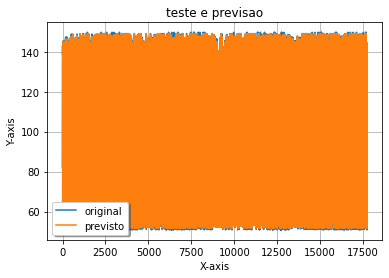

In [151]:
x_ax = range(0, previsao_cross.count())
y_pred=previsao_cross.select("prediction").collect()
y_orig=previsao_cross.select("cost").collect()
 
plt.plot(x_ax, y_orig, label="original")
plt.plot(x_ax, y_pred, label="previsto")
plt.title("teste e previsao")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 